# 👋 Lecture 1: Welcome to *Probabilistic Machine Learning* MA485

**MA300 follow-up • math-first • model-building mindset**

> *Philosophy:* The world is uncertain; we reason in **probabilities**, not absolutes. We’ll learn to **model** that uncertainty—and to **generate** new data—from first principles.



=== Discriminative vs Density Check ===

Typical (near data)
x = [1. 1.]
p(y=1|x)        = 0.999737
log p(x)        = -1.688
p(x)            = 1.849e-01
[Joint] p(y|x)p(x)      = 1.849e-01
[Joint] log p(y|x) + log p(x) = -1.688

Far (OOD-ish)
x = [3.6 3.6]
p(y=1|x)        = 1.000000
log p(x)        = -7.267
p(x)            = 6.982e-04
[Joint] p(y|x)p(x)      = 6.982e-04
[Joint] log p(y|x) + log p(x) = -7.267


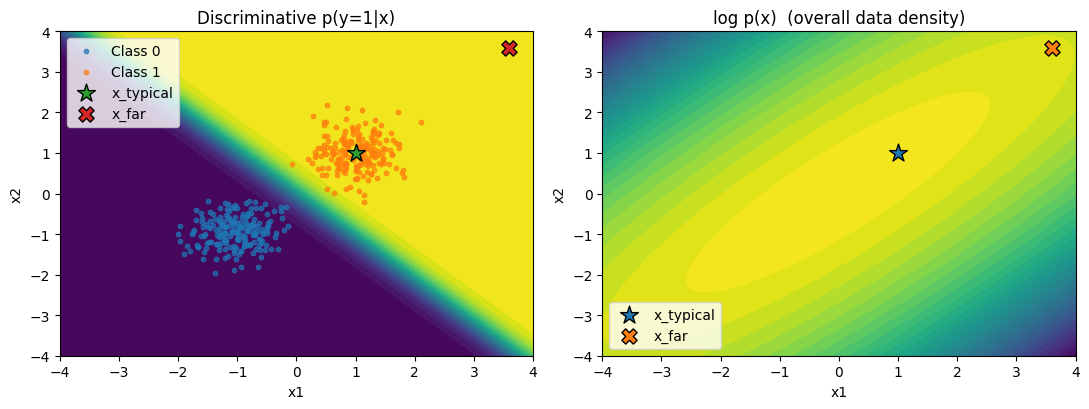

In [ ]:
# %% [markdown]
# # Why modeling p(x) matters—even with a perfect linear separator
# We train a discriminative model p(y|x) (logistic regression) on linearly separable data.
# Then we compare two points on the SAME side of the boundary:
#   - x_typical: near the training data (high p(x))
#   - x_far: far from all data (low p(x))
# The classifier's p(y|x) is ~1 for both, but p(x) is tiny for x_far.
# The joint score p(y|x)*p(x) becomes small for x_far, signaling low support.

# %%
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1) Make linearly separable 2D data (two Gaussian blobs)
# ---------------------------
n_per_class = 200
mean0 = torch.tensor([-1.0, -1.0])
mean1 = torch.tensor([+1.0, +1.0])
cov = 0.15 * torch.eye(2)

x0 = torch.distributions.MultivariateNormal(mean0, cov).sample((n_per_class,))
x1 = torch.distributions.MultivariateNormal(mean1, cov).sample((n_per_class,))
X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(n_per_class), torch.ones(n_per_class)]).unsqueeze(1)

# Shuffle
perm = torch.randperm(X.size(0))
X, y = X[perm], y[perm]

X_train, y_train = X.to(device), y.to(device)

# ---------------------------
# 2) Train a simple linear classifier p(y=1|x) = sigmoid(w^T x + b)
# ---------------------------
model = nn.Sequential(nn.Linear(2, 1)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(500):
    optimizer.zero_grad()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

# ---------------------------
# 3) Fit a simple density model p(x): single Gaussian to ALL data
#    (You can swap for KDE or class-conditional Gaussians.)
# ---------------------------
X_cpu = X  # keep on CPU for stats
mean_all = X_cpu.mean(dim=0)
X_centered = X_cpu - mean_all
# Unbiased covariance
cov_all = (X_centered.t() @ X_centered) / (X_centered.size(0) - 1)
cov_all = cov_all + 1e-6 * torch.eye(2)  # numerical stability

# Use slogdet (more stable than logdet)
sign, logabsdet = torch.slogdet(cov_all)
assert sign > 0, "Covariance must be positive definite."
dim = X_cpu.size(1)
log_norm_const = -0.5 * (dim * math.log(2.0 * math.pi) + logabsdet.item())

def log_p_x(x):
    """
    Multivariate normal log-density N(mean_all, cov_all).
    x: (..., 2) tensor on CPU
    """
    xc = x - mean_all
    inv_cov = torch.inverse(cov_all)
    m = torch.sum((xc @ inv_cov) * xc, dim=-1)  # Mahalanobis distance
    return log_norm_const - 0.5 * m

sigmoid = torch.nn.Sigmoid()

# ---------------------------
# 4) Two test points: both on the positive side of the learned boundary
#    - x_typical: near the class-1 cluster center
#    - x_far: far away along the same direction but still visible on the plot
# ---------------------------
x_typical = mean1.clone()                     # near data
x_far     = mean1 + torch.tensor([2.6, 2.6])  # location of x_far

def evaluate_point(x, label_for_joint=1):
    x_t = x.to(device).float().unsqueeze(0)
    with torch.no_grad():
        logit = model(x_t).squeeze()
        p_y1_given_x = sigmoid(logit).item()
        p_y0_given_x = 1.0 - p_y1_given_x

    # density on CPU (to use precomputed stats)
    lp = float(log_p_x(x.unsqueeze(0)))  # log p(x)
    p = math.exp(lp)                     # p(x)

    # "Joint score" for the asserted label: p(y|x) * p(x)
    if label_for_joint == 1:
        joint = p_y1_given_x * p
        log_joint = math.log(max(p_y1_given_x, 1e-12)) + lp
    else:
        joint = p_y0_given_x * p
        log_joint = math.log(max(p_y0_given_x, 1e-12)) + lp

    return {
        "x": x.numpy(),
        "p_y1|x": p_y1_given_x,
        "log_p_x": lp,
        "p_x": p,
        "joint": joint,
        "log_joint": log_joint
    }

res_typical = evaluate_point(x_typical, label_for_joint=1)
res_far     = evaluate_point(x_far,     label_for_joint=1)

print("=== Discriminative vs Density Check ===")
for name, res in [("Typical (near data)", res_typical), ("Far (OOD-ish)", res_far)]:
    print(f"\n{name}")
    print(f"x = {res['x']}")
    print(f"p(y=1|x)        = {res['p_y1|x']:.6f}")
    print(f"log p(x)        = {res['log_p_x']:.3f}")
    print(f"p(x)            = {res['p_x']:.3e}")
    print(f"[Joint] p(y|x)p(x)      = {res['joint']:.3e}")
    print(f"[Joint] log p(y|x) + log p(x) = {res['log_joint']:.3f}")

# ---------------------------
# 5) Visualization
# ---------------------------
# Meshgrid for contours
grid_lim = 4.0
g = 200
xs = torch.linspace(-grid_lim, grid_lim, g)
ys = torch.linspace(-grid_lim, grid_lim, g)
XX, YY = torch.meshgrid(xs, ys, indexing='xy')
grid = torch.stack([XX.reshape(-1), YY.reshape(-1)], dim=1)

# Classifier probability surface
with torch.no_grad():
    probs = sigmoid(model(grid.to(device))).view(g, g).cpu()

# Density log p(x) surface (overall p(x))
LP = log_p_x(grid).view(g, g)

fig, axs = plt.subplots(1, 2, figsize=(11, 4.2))

# (a) Classifier confidence
axs[0].contourf(XX, YY, probs, levels=30)
axs[0].scatter(x0[:,0], x0[:,1], s=10, label='Class 0', alpha=0.7)
axs[0].scatter(x1[:,0], x1[:,1], s=10, label='Class 1', alpha=0.7)
axs[0].scatter([x_typical[0]], [x_typical[1]], marker='*', s=180, edgecolor='k', label='x_typical')
axs[0].scatter([x_far[0]], [x_far[1]], marker='X', s=120, edgecolor='k', label='x_far')
axs[0].set_title("Discriminative p(y=1|x)")
axs[0].legend(loc='upper left')
axs[0].set_xlabel("x1"); axs[0].set_ylabel("x2")

# (b) Data density log p(x)
axs[1].contourf(XX, YY, LP, levels=30)
axs[1].scatter([x_typical[0]], [x_typical[1]], marker='*', s=180, edgecolor='k', label='x_typical')
axs[1].scatter([x_far[0]], [x_far[1]], marker='X', s=120, edgecolor='k', label='x_far')
axs[1].set_title("log p(x)  (overall data density)")
axs[1].legend(loc='lower left')
axs[1].set_xlabel("x1"); axs[1].set_ylabel("x2")

plt.tight_layout()
plt.show()

# %% [markdown]
# **Takeaway.** A purely discriminative model p(y|x) can be overconfident for points that are
# far from the training distribution (high p(y|x) but low p(x)). Modeling (or estimating)
# the data density p(x) helps reveal low-support regions and temper overconfidence via the joint p(y|x) p(x).


---

## 🔎 Comments on the Example

### 1. What the discriminative model says
- The linear classifier (logistic regression) learns a separating line between the two Gaussian clusters.  
- For points near the **center of a cluster** (e.g., the “typical” ⭐ point), $p(y \mid x)$ is close to 1, which makes sense.  
- But for the **far away point** (the “X”), the classifier *still* outputs $p(y \mid x) \approx 1$ — because it’s on the same side of the line, and logistic regression only cares about the relative position to the boundary.

👉 **Lesson**: Discriminative models can be overconfident even for points where we have never seen data.  

---

### 2. What the density $p(x)$ tells us
- When we also fit a simple density model $p(x)$, we see that:  
  - For the **typical** point, $p(x)$ is high (it lies in a region where many training samples exist).  
  - For the **far** point, $p(x)$ is tiny — because it is far away from all the observed data.  
- This means the **joint probability** $p(x,y) = p(y \mid x) p(x)$ is much lower for the far point than for the typical point.

👉 **Lesson**: By combining discriminative information with density, we temper our confidence in regions with low data support.  

---

### 3. Takeaway for generative modeling
- In **MA300**, we focused on *discriminative learning*: draw a line, separate classes, assign labels.  
- In **probabilistic machine learning**, we emphasize *modeling uncertainty*:  
  - Knowing $p(y \mid x)$ alone is not enough — we must also ask whether $x$ itself is plausible.  
  - Generative models learn $p(x)$ (and often $p(x,y)$), so they are better suited to detect “strange” points, model uncertainty, and generate new data.  

---

### 4. Motivation
This toy example directly motivates why **modern generative models** are important:  
- They not only predict labels, but also understand the *distribution of the data itself*.  
- This ability is crucial in real-world settings like **out-of-distribution detection**, **anomaly detection**, and **uncertainty quantification**.  




---
---

## 🤔 Why modeling $p(x)$ is hard

**Bottom line:** $p(x)$ (the data distribution) can be complex, high-dimensional, and multi-modal. Estimating it well is fundamentally harder than drawing a separating line.

### Key challenges
- **Curse of dimensionality:** In $d$ dimensions, data become *sparse*. Distances grow, neighborhoods empty out, and nonparametric estimators (like KDE) need exponentially more data to stay accurate.
- **Multi-modality & geometry:** Real data live on **manifolds** with holes, clusters, symmetries (e.g., rotations). A single Gaussian cannot capture that.
- **Normalization & tractability:** Many expressive models define densities with terms that are hard to compute.
- **Computation vs. fidelity trade-off:** Exact likelihoods are expensive; approximate ones are easier but introduce bias/variance.
- **Evaluation is tricky:** Good likelihood does not always mean good samples (and vice versa). We need multiple metrics: likelihood, calibration, FID-like sample quality, OOD detection.




---

## 🌐 Major Generative Model Families

We cover **Autoregressive Models, GANs, Normalizing Flows, Energy-Based Models, Diffusion Models, and VAEs**.  
For each: formula → benefits → limitations → math background needed.

---

<img src="https://www.csd.uoc.gr/~hy673/images/slider/01_l.jpg" width="600">


### 🔗 Autoregressive Models
**Formula:**  
Factorize the joint distribution using the chain rule:  
$$
p_\theta(x) = \prod_{i=1}^D p_\theta(x_i \mid x_{<i})
$$  
Examples: PixelCNN, GPT-style models.

**Benefits:**  
- Exact likelihood.  
- Simple training with teacher forcing.  
- Powerful for sequences (language, time series).  

**Limitations:**  
- Sampling is sequential (slow for high dimension).  
- Captures local structure well but long-range dependencies can be tricky.  

**Key math:** Chain rule of probability, conditional distributions, sequence modeling.  

---

### 🎭 Variational Autoencoders (VAEs)
**Formula:**  
Latent-variable model:  
$$
p_\theta(x) = \int p_\theta(x \mid z) p(z) \, dz
$$  
ELBO objective:  
$$
\log p_\theta(x) \ge
\mathbb{E}_{q_\phi(z\mid x)}[\log p_\theta(x \mid z)]
- \mathrm{KL}(q_\phi(z\mid x)\,\|\,p(z))
$$

**Benefits:**  
- Principled latent-variable framework.  
- Tractable training via ELBO.  

**Limitations:**  
- ELBO is only a bound; samples can look blurry.  
- Sensitive to prior/posterior choice.  

**Key math:** Bayes’ rule, KL divergence, variational inference, reparameterization trick.  


---

### 🎮 Generative Adversarial Networks (GANs)
**Formula:**  
Two-player minimax game between generator $G_\theta(z)$ and discriminator $D_\phi(x)$:  
$$
\min_\theta \max_\phi \;
\mathbb{E}_{x \sim p_{\text{data}}} [\log D_\phi(x)] +
\mathbb{E}_{z \sim p(z)} [\log(1 - D_\phi(G_\theta(z)))]
$$

**Benefits:**  
- Generate sharp, realistic samples.  
- Does not require explicit density function.  
- Very successful in images, videos, creative tasks.  

**Limitations:**  
- Training is unstable (mode collapse, non-convergence).  
- No explicit likelihood.  
- Difficult to evaluate quantitatively.  

**Key math:** Minimax optimization, Jensen–Shannon divergence, game theory basics.  

---

### 🔁 Normalizing Flows
**Formula:**  
Transform base noise $z \sim p_z(z)$ (e.g. Gaussian) into data $x = f_\theta(z)$ with invertible $f_\theta$:  
$$
p_\theta(x) = p_z(f_\theta^{-1}(x)) \, \left| \det \frac{\partial f_\theta^{-1}(x)}{\partial x} \right|
$$

**Benefits:**  
- Exact likelihoods, efficient sampling.  
- Continuous and expressive distributions.  

**Limitations:**  
- Invertibility constrains architectures.  
- Jacobian determinants costly.  

**Key math:** Change of variables, Jacobians, linear algebra (inverse, determinant).  

---

### ⚡ Energy-Based Models (EBMs)
**Formula:**  
$$
p_\theta(x) = \frac{e^{-E_\theta(x)}}{Z(\theta)},
\qquad Z(\theta) = \int e^{-E_\theta(x)} dx
$$

**Benefits:**  
- Very flexible, no invertibility required.  
- Can represent complex multi-modal densities.  

**Limitations:**  
- Partition function $Z(\theta)$ intractable.  
- Training/sampling requires MCMC (slow).  

**Key math:** Exponential families, partition functions, Monte Carlo / MCMC.  

---
### 🌫 Diffusion & Score-Based Models
**Formula:**  

$$
q(x_t \mid x_0)  =Normal (x_t \;|\; \sqrt{\alpha_t}\, x_0,\; (1-\alpha_t) I)
$$

Backward: learn score $\nabla_x \log p_t(x)$ and sample via reverse SDE/ODE.

<img src="https://www.siam.org/media/agxdzywa/figure1.jpg" width="600">



In [2]:
from IPython.display import Image, display

display(Image(url="https://yang-song.net/assets/img/score/perturb_vp.gif", width=600))
from IPython.display import Image, display

display(Image(url="https://yang-song.net/assets/img/score/denoise_vp.gif", width=600))



### Probability Flow ODE

The reverse SDE:
$$
dx = \Big( f(x,t) - g(t)^2 s_\theta(x,t) \Big) dt + g(t) d\bar{w},
$$

has the same marginals as the deterministic **probability flow ODE**:
$$
\frac{dx}{dt} = f(x,t) - \tfrac{1}{2} g(t)^2 s_\theta(x,t).
$$

- Both describe the same evolving distributions \(p_t(x)\).
- The SDE is stochastic; the ODE is deterministic.
- This makes score models behave like **likelihood-based normalizing flows**.

<img src="https://yang-song.net/assets/img/score/teaser.jpg" width="600">



<img src="https://yang-song.net/assets/img/score/score_contour.jpg" width="600">

**Benefits:**  
- State of the art for images, audio, text.  
- Very flexible, stable training.  

**Limitations:**  
- Sampling is slow (many steps).  
- Likelihood evaluation indirect.  

**Key math:** Gaussian distributions, SDEs/ODEs, score functions.  

<img src="https://yang-song.net/assets/img/score/langevin.gif" width="600">





🌊 **Flow Matching Models**

**Formula:**

Learn a vector field  
$$
\frac{dx}{dt} = v_\theta(x,t)
$$  
so that transporting particles from a base distribution (e.g., Gaussian) matches the data distribution.

<img src="https://www.alextong.net/publication/tong-conditional-2023/featured_huaededdc51f53a118393b2e3b479edec3_1295207_a8982bafdd092694b355d965dc2a0d36.webp" width="600">


**Training:**

Match the model flow $v_\theta(x,t)$ to the target flow using conditional expectations  
(minimize squared error between model flow and ideal flow from data).

**Benefits:**

- Deterministic ODE sampling → faster than diffusion (fewer steps).
- Direct likelihood evaluation via change of variables.
- Unifies normalizing flows and diffusion models.

**Limitations:**

- Training can be less stable (sensitive to flow parametrization).
- Requires careful base distribution and matching scheme.

**Key math:** Continuity equation, change of variables, ODE integration, conditional expectations.


<img src="https://yang-song.net/assets/img/score/pitfalls.jpg" width="600">


---

## 📊 Comparison at a Glance

| Model Type            | Formula (core idea) | Benefits | Limitations | Key Math |
|-----------------------|----------------------|----------|-------------|----------|
| **Autoregressive**    | $p(x)=\prod_i p(x_i\mid x_{<i})$ | Exact likelihood, simple training | Slow sequential sampling | Chain rule, conditional prob. |
| **VAEs**              | Maximize ELBO on latent model | Tractable, latent variables | ELBO gap, blurry samples | Variational inference, KL divergence |
| **GANs**              | $\min_G \max_D \; \mathbb{E}[\log D(x)]+\mathbb{E}[\log(1-D(G(z)))]$ | Sharp, realistic samples | Unstable training, no likelihood | Minimax optimization, divergences |
| **Normalizing Flows** | $p(x) = p_z(f^{-1}(x))|\det J|$ | Exact likelihood, invertible sampling | Invertibility constraints, costly Jacobians | Change of variables, determinants |
| **EBMs**              | $p(x) \propto e^{-E(x)}$ | Flexible, multi-modal | Intractable $Z$, MCMC needed | Exponential families, MCMC |
| **Diffusion/Score**   | Forward noise, learn $\nabla_x \log p_t(x)$ | SOTA, robust training | Slow sampling, indirect likelihood | SDE/ODE, Gaussian noise, score functions |

---

## ✨ Takeaway
- **Autoregressive:** exact and effective for sequences, but sequential bottleneck.  
- **GANs:** unmatched realism, but fragile training and no likelihoods.  
- **Normalizing Flows:** exact but architecture-limited.  
- **EBMs:** flexible but hard to train/sample.  
- **Diffusion:** powerful but slow.  
- **VAEs:** efficient but approximate.  

All require a strong grasp of **probability, calculus, linear algebra, and optimization**.

---

## Why generative models (now)?
- **Synthesis:** Create realistic images, audio, molecules, and text by sampling from learned distributions.
- **Understanding:** Learn **structure** in data (latent variables, manifolds, symmetries) beyond prediction.
- **Decision-making under uncertainty:** Bayes’ rule + likelihoods → principled reasoning.
- **Modern impact:** VAEs, normalizing flows, diffusion/score models, and flow matching fuel state-of-the-art systems.

---

## What you’ll learn (and use)
- **Core tools:** Probability, Bayes’ rule, KL/JS, change of variables & Jacobians, gradients/Hessians.
- **Models:** autoregressive → VAEs → flows → energy-based→diffusion/score models → flow matching;   as context.
- **Algorithms:** Variational inference, reparameterization, Langevin/ODE/SDE samplers.
- **Engineering:** From toy 2D mixtures to image models—training stability, scaling, and evaluation.

---

## How this course is different
- **Math-forward:** We will derive before we code. Rigor clarifies design choices.
- **Hands-on:** Short **in-class quizzes** and implementation exercises cement ideas.
- **Bridging theory ↔ practice:** You’ll see how assumptions (likelihoods, priors, parameterizations) shape performance.



---

## 📍 Roadmap with Key Math Formulas

1. 🔹 **Foundations**
   - **Bayes’ rule:**  
     $$
     p(y \mid x) = \frac{p(x \mid y)  p(y)}{p(x)}
     $$
   - **KL divergence:**  
     $$
     D_{\text{KL}}(p \|| q) = \int p(x) \log \frac{p(x)}{q(x)} dx
     $$
   - **Entropy:**  
     $$
     H(p) = -\int p(x) \log p(x) dx
     $$

---

2. **Latent-variable models (VAEs)**
   - **Latent variable model:**  
     $$
     p_\theta(x) = \int p_\theta(x \mid z) p(z) dz
     $$
   - **Evidence Lower Bound (ELBO):**  
$$
\log p_\theta(x) \;\ge\;
\mathbb{E}_{q_\phi(z \mid x)} \big[ \log p_\theta(x \mid z) \big]
- D_{\text{KL}}\!\big(q_\phi(z \mid x) \,\|\, p(z)\big)
$$
---

3. **Change-of-variables modeling (Normalizing flows)**
   - **Change of variables:**  
     $$
     p_\theta(x) = p_z\big(f_\theta^{-1}(x)\big)
     \left| \det \frac{\partial f_\theta^{-1}(x)}{\partial x} \right|
     $$
   - Here $f_\theta$ is an invertible neural net, and the Jacobian determinant rescales density.

---
4. **Score-based / Diffusion models**

- **Forward noising process (known, tractable):**

$$
q(x_t \mid x_0) = \text{Normal}\big(x_t \;|\; \sqrt{\alpha_t}\, x_0,\; (1-\alpha_t) I\big)
$$

Here, $x_0 \sim p_{\text{data}}(x)$ and $\{\alpha_t\}$ is a noise schedule.  
This defines how clean data gradually becomes Gaussian noise.

---

- **Marginal noisy distribution (intractable):**

$$
q(x_t) = \int q(x_t \mid x_0)\, p_{\text{data}}(x_0)\, dx_0
$$

We cannot compute this integral explicitly, but we can sample from it easily by drawing $x_0 \sim p_{\text{data}}$ and then corrupting with noise.

---

- **Score function (to learn):**

$$
s_\theta(x_t, t) \;\approx\; \nabla_x \log p_t(x_t)
$$

The neural network $s_\theta$ learns the gradient of the log-density at noise level $t$.  
This tells us the direction in which data density increases.

---

- **Training objective (denoising score matching):**

$$
\min_\theta \;
\mathbb{E}_{t,\,x_0,\,x_t}\;
\big\|\, s_\theta(x_t, t) \;-\; \nabla_{x_t} \log q(x_t \mid x_0) \,\big\|^2
$$

Since $\nabla_{x_t} \log q(x_t \mid x_0)$ is Gaussian and tractable, we can train $s_\theta$ without needing the true $q(x_t)$.


- **Reverse process (continuous-time view):**

Forward SDE:
$$
dx = f(x,t)\,dt + g(t)\, dW_t, \qquad x(0)\sim p_{\text{data}}
$$

Reverse-time SDE (to sample):
$$
dx = \big[f(x,t) - g(t)^2 \nabla_x \log p_t(x)\big]\,dt + g(t)\, d\bar W_t,
\qquad x(T)\sim \text{Normal}(0,I)
$$

Here $d\bar W_t$ is reverse-time Brownian motion.  
Replacing $\nabla_x \log p_t(x)$ with the learned $s_\theta(x,t)$ gives us the generative model.

---

- **Sampling algorithm (ODE version):**

$$
\frac{dx}{dt} = f(x,t) - \tfrac{1}{2} g(t)^2 \, s_\theta(x,t)
$$

Integrate this ODE numerically from Gaussian noise $x_T \sim \text{Normal}(0,I)$ back to $x_0$ to generate samples.



---

5. **Flow Matching**

- **Goal:** Learn a **deterministic probability flow** that transports a simple base distribution to the data distribution *without* explicitly learning the reverse SDE/score.

---

- **Continuity (transport) equation:** the flow $v_\theta(x,t)$ induces a time-evolving density $p_t(x)$ via
$$
\frac{\partial p_t(x)}{\partial t} \;+\; \nabla_x \!\cdot\! \big( p_t(x)\, v_\theta(x,t) \big) \;=\; 0 .
$$

- **Probability path:** choose an explicit path (interpolation) from base $p_0$ to data $p_1$; for example, a Gaussian-smoothed linear path (a common choice):
$$
x_t \;=\; (1-t)\,x_0 \;+\; t\,x_1 \;+\; \sigma(t)\,\varepsilon, \quad
x_0 \sim p_0,\; x_1 \sim p_{\text{data}},\; \varepsilon \sim \mathcal{N}(0,I) ,
$$
which defines a target path density $\pi_t(x)$.

- **Target (oracle) velocity along the path:** differentiate the path definition to get the *true* velocity of the moving particle,
$$
u^\star(x,t) \;=\; \mathbb{E}\!\left[ \frac{d x_t}{dt} \,\middle|\, x_t = x \right] .
$$
Intuitively: the conditional expected velocity of particles that pass through $x$ at time $t$ under the chosen path.

- **Flow-matching objective (regression to the oracle velocity):**
$$
\min_\theta \; \mathbb{E}_{t \sim \text{Normal}(0,1)} \;
\mathbb{E}_{(x_0, x_1, \varepsilon)} \;
\Big\| \, v_\theta\!\big(x_t, t\big) \;-\; u^\star\!\big(x_t, t\big) \, \Big\|^2 .
$$
Because $u^\star$ is *analytically known* for many choices of path $\pi_t$, we can train $v_\theta$ by simple supervised regression—no reverse SDE or score needed.

- **Sampling (deterministic ODE):**
$$
\frac{d x}{d t} \;=\; v_\theta(x,t),
\qquad x(0) \sim p_0 \;\; \xrightarrow[\text{integrate } t:0\to1]{}\;\; x(1) \sim p_{\text{model}} \approx p_{\text{data}} .
$$
Numerically integrate this ODE (e.g., RK4) from $t=0$ to $t=1$ to generate samples.

**Key math to know**
- Continuity equation and vector calculus (divergence).
- ODE solvers and stability.
- Conditional expectations and reparameterizations for deriving $u^\star$.
- Connections to optimal transport (probability flows) are helpful conceptually.




---

### 📚 Deriving the Variational Lower Bound for Diffusion Models

In this course, we’ll **derive the training objective** for each model from scratch.

For example, we will derive the **evidence lower bound (ELBO)** for diffusion models as outlined in:

🔗 [Lilian Weng’s blog: “What are Diffusion Models?”](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

> This is one of the most widely cited and well-explained resources for understanding diffusion modeling, especially how the training loss arises as a variational lower bound.

---

✅ **This is just one example to show the level of math you should expect to see in this course.**  
We’ll derive expressions involving expectations, KL divergences, Gaussian log-likelihoods, and parameterized reverse processes — step by step.


📌 We'll revisit this during the "Score-based / Diffusion Models" module — but feel free to read ahead to build some intuition.

---


# 📘 MA485: Probabilistic Machine Learning  
Instructor: **Prof. Yuanzhe Xi** | yuanzhe.xi@emory.edu  
Lectures: **MW 10:00–11:15 AM**, MSC W307C  
Office Hours: **Tues 1–3 PM**, MSC E428  

---

## 🧠 Course Description  
This course explores the **probabilistic foundations of modern machine learning**, with an emphasis on **deep generative models** and their theory, algorithms, and implementation. Topics include:

- Variational Autoencoders (VAEs)
- Generative Adversarial Networks (GANs)
- Autoregressive Models
- Normalizing Flows
- Diffusion / Score-Based Models
- Large Language Models (LLMs)

---

## 🎯 Learning Goals  
By the end of this course, you will:

- Understand core probabilistic principles in ML
- Implement and debug generative models using PyTorch
- Apply models to real-world datasets
- Analyze model uncertainty and performance

---

## 📚 Resources  
**Main course material**: Python notebooks via **Canvas**  
Recommended references:
- [Learning Theory from First Principles](https://www.di.ens.fr/~fbach/ltfp_book.pdf)
- [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html)
- [Deep Generative Modeling](https://github.com/jmtomczak/intro_dgm)

---

## ✅ Prerequisites  
- **Math 221**, **Math 362**, and **MA300 (recommended)**
- Comfort with probability, calculus, linear algebra, and Python

---

## 📝 Grading Policy  
| Component           | Weight | Notes                                                |
|--------------------|--------|------------------------------------------------------|
| In-class quizzes    | 50%    | ~2 per week; lowest 3 dropped                       |
| Mini-projects       | 15%    | Group work (2–3 people), submitted via Canvas       |
| **Midterms (x2)**   | **20%** | **In-class on 9/24 and 11/5**                      |
| Final project       | 15%    | Proposal + spotlight + presentation + final report  |

### 📈 Grade Scale  
A ≥ 93, A− ≥ 90, B+ ≥ 87, ..., D ≥ 60, F < 60

---

## 🧪 Final Project Milestones  
- Proposal: due mid-November (2-page PDF)  
- Spotlight: 5-minute teaser on **Dec 8**  
- Full Presentation: during finals week  
- Final Report: **due Dec 15**

Projects must apply or extend a generative model on a dataset (~1M data points). Code must be submitted.

---

## 🗓 Tentative Schedule  

| Week | Dates | Topics |
|------|-------|--------|
| 1 | 8/27 | Introduction + course logistics |
| 2 | 9/3 | Autoregressive models |
| 3 | 9/8, 9/10 | LSTM, Transformers |
| 4 | 9/15, 9/17 | Variational Autoencoders (VAEs) |
| 5 | 9/22, **9/24** | GANs + **Midterm 1** |
| 6 | 9/29, 10/1 | Normalizing Flows |
| 7 | 10/6, 10/8 | Diffusion models |
| 8 | Fall break |  |
| 9 | 10/15, 10/20, 10/22 | Score-based models, ODE/SDE |
| 10 | 10/27, 10/29 | Evaluating Generative Models |
| 11 | 11/3, **11/5** | LLM In-Context Learning + **Midterm 2** |
| 12 | 11/10, 11/12 | LLM Inference, RAG |
| 13 | 11/17, 11/19 | LLM Reasoning, Chain of Thought |
| 14 | 11/24 | Multimodal Models I |
| 15 | 12/1, 12/3 | Multimodal Models II + Review |
| 16 | 12/8 | Final project spotlight presentations |
| Finals | 12/15 | 📢 Final Presentations @ 8:30–10:30 AM |

---

## 💻 Technology & Submission  
- **Canvas**: for all announcements, submissions, and quizzes  
- **CamScanner**: for scanning handwritten work as PDFs  
- **Colab / Jupyter**: for coding and notebook assignments

---

## 📌 Academic Policies  
- **Honor Code** applies to all work  
- **No make-up quizzes** (lowest 3 dropped)  
- **Make-up midterms only** with advance notice + valid documentation  
- **Use Canvas discussion boards** for course Q&A  

For academic support:  
- [EPASS Tutoring](https://college.emory.edu/oue/academic-support/epass/)  
- [DAS (Accessibility Services)](https://accessibility.emory.edu/)  
- [OUE (Office of Undergraduate Education)](https://college.emory.edu/oue/)

---




Any question?